In [ ]:
import glob
import os
import itertools
from itertools import islice

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import MobileNetV2, DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, LSTM, GlobalAveragePooling2D, TimeDistributed, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint


In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
def labels_to_number(path):
    """
    Convert string labels in numbers.

    :param path: path to folder.
    :return: a dictionary.
    """
    classes = [i.split(os.path.sep)[4] for i in glob.glob(path + '*')]
    classes.sort()
    print(classes)
    labels_dict = {}
    for i, label in enumerate(classes):
        # print(label)
        labels_dict[label] = i

    return labels_dict


def videos_to_dict(path, labels):
    """
    Read the videos and return a dict like {'path_to_video', 'label'}.

    :param path: path to videos folder.
    :param labels: labels as dict.
    :return: a dictionary.
    """
    videos_dict = {}
    for root, dirs, files in os.walk(os.path.relpath(path)):
        for file in files:
            video_name = os.path.join(root, file)
            dir_name = os.path.basename(os.path.dirname(video_name))  # label
            videos_dict[video_name] = labels[dir_name]

    return videos_dict

In [6]:
class VideoFrameGenerator(keras.utils.Sequence):
    """
    The VideoFrameGenerator extracts n frames from a video.

    You can choose between two sampling mode:
    - Mode 1: extracts n frames from the entire video.
    - Mode 2: extracts n frames from the entire video, but first performs a
    pre-sampling to eliminate the initial and final sequences in witch no
    movements appear.
    """

    def __init__(self, list_IDs, labels, batch_size=32, dim=(32, 32),
                 n_channels=3, n_sequence=10, shuffle=True, type_gen='train'):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_sequence = n_sequence  # number of frames to extract
        self.shuffle = shuffle
        self.type_gen = type_gen
        self.sampl_mode = '2'
        self.aug_gen = ImageDataGenerator()
        print(f'Videos: {len(self.list_IDs)}, batches per epoch: '
              f'{int(np.floor(len(self.list_IDs) / self.batch_size))}')
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def frame_sampling(self, len_frames):
        """
        Sample the video with the chosen policy.

        :param len_frames: video length (in frames)
        :return: the indexes of the sampled frames.
        """
        # create a list of frames
        frames = list(range(len_frames))

        # sampling choice
        if self.sampl_mode == '1':
            # create chunks
            chunks = list(self.get_chunks(frames, self.n_sequence))
            sampling = self.sampling_mode_1(chunks)
        elif self.sampl_mode == '2':
            sampling = self.sampling_mode_2(frames, self.n_sequence)
        else:
            raise ValueError

        return sampling

    def sampling_mode_1(self, chunks):
        """
        Select 10 frames from the entire sequence.

        :param chunks: blocks from which to select frames.
        :return: the indexes of the 10 frames sampled.
        """
        sampling = []
        for i, chunk in enumerate(chunks):
            if i == 0 or i == 1:
                sampling.append(chunk[-1])  # get the last frame
            elif i == (len(chunks) - 1) or i == (len(chunks) - 2):
                sampling.append(chunk[0])  # get the first frame
            else:
                sampling.append(chunk[len(chunk) // 2])  # get the central frame

        return sampling

    def sampling_mode_2(self, frames, n_sequence):
        """
        Do a pre-sampling by creating 12 chunks. Then apply the first sampling
        mode (sampling_mode_1 function).

        :param frames: list of frames.
        :param n_sequence: number of frames to sample.
        :return: the indexes of the 10 frames sampled.
        """
        # create 12 chunks
        chunks = list(self.get_chunks(frames, 12))

        # remove the first and the last chunk
        sub_chunks = chunks[1:-1]

        # get a the new list of frames
        sub_frame_list = list(itertools.chain.from_iterable(sub_chunks))

        # create n_sequence(10) chunks
        new_chunks = list(self.get_chunks(sub_frame_list, n_sequence))

        sampling = self.sampling_mode_1(new_chunks)

        return sampling

    def get_chunks(self, l, n):
        # divide indexes list in n chunks
        k, m = divmod(len(l), n)
        return (l[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in
                range(n))

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, self.n_sequence, *self.dim,
                      self.n_channels))
        Y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):  # ID: path to file
            path_file = ID
            cap = cv2.VideoCapture(path_file)
            # get number of frames
            length_file = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            index_sampling = self.frame_sampling(length_file)  # sampling indxs

            for j, n_pic in enumerate(index_sampling):
                cap.set(cv2.CAP_PROP_POS_FRAMES, n_pic)  # jump to that index
                ret, frame = cap.read()
                new_image = cv2.resize(frame, self.dim)
                X[i, j, :, :, :] = new_image

            if self.type_gen == 'train':
                X[i,] = self.sampling_augmentation(X[i,]) / 255.0
            else:
                X[i,] = X[i,] / 255.0

            Y[i] = self.labels[ID]
            cap.release()

            # for debugging
            # self.save_frame_sampling(X, i, ID, len(index_sampling))

        return X, Y

    def sampling_augmentation(self, sequence):
        """
        - `'theta'`: Float. Rotation angle in degrees.
        - `'tx'`: Float. Shift in the x direction. - vertical shift (height)
        - `'ty'`: Float. Shift in the y direction. - horizontal shift (width)
        - `'shear'`: Float. Shear angle in degrees.
        - `'zx'`: Float. Zoom in the x direction. - vertical zoom
        - `'zy'`: Float. Zoom in the y direction. - horizontal zoom
        - `'flip_horizontal'`: Boolean. Horizontal flip.
        - `'flip_vertical'`: Boolean. Vertical flip.
        - `'channel_shift_intensity'`: Float. Channel shift intensity.
        - `'brightness'`: Float. Brightness shift intensity.
        """
        transformations = ['theta', 'tx', 'ty', 'zx', 'zy', 'flip_horizontal',
                           'brightness']

        # random choice of number of transformations
        random_transforms = np.random.randint(2, 4)  # min 2 - max 3
        # random choice of transformations
        transforms_idxs = np.random.choice(len(transformations),
                                           random_transforms, replace=False)

        transfor_parameters = {}
        for idx in transforms_idxs:
            if transformations[idx] == 'theta':
                transfor_parameters['theta'] = np.random.randint(-5, 5)

            elif transformations[idx] == 'tx':
                transfor_parameters['tx'] = np.random.randint(-10, 10)

            elif transformations[idx] == 'ty':
                transfor_parameters['ty'] = np.random.randint(-15, 15)

            elif transformations[idx] == 'zx':
                transfor_parameters['zx'] = np.random.uniform(0.6, 1.05)

            elif transformations[idx] == 'zy':
                transfor_parameters['zy'] = np.random.uniform(0.6, 1.05)

            elif transformations[idx] == 'flip_horizontal':
                transfor_parameters['flip_horizontal'] = True

            elif transformations[idx] == 'brightness':
                transfor_parameters['brightness'] = np.random.uniform(0.4, 0.6)

        len_seq = sequence.shape[0]
        for i in range(len_seq):
            sequence[i] = self.aug_gen.apply_transform(sequence[i],
                                                       transfor_parameters)

        return sequence

    def save_frame_sampling(self, samp_imgs, i, img_path, n_frames):
        # concatenate all frames
        train_frame = ()
        for n_f in range(n_frames):
            train_frame = (*train_frame, samp_imgs[i, n_f,] * 255.0)

        # get the train of frame in one image
        full_img = np.concatenate(train_frame, axis=1)

        # info
        img_name = (os.path.split(img_path)[1])[:-4]
        img_label = os.path.split(os.path.split(img_path)[0])[1]
        
        if not os.path.isdir('Sampling/'):
            os.mkdir('Sampling/')
        # save the image
        if not os.path.isdir('Sampling/sampling_test/'):
            os.mkdir('Sampling/sampling_test/')

        name_file = self.type_gen + '_' + img_label + '_' + img_name
        cv2.imwrite('Sampling/sampling_test/' + name_file + '.jpg', full_img)

In [7]:
def create_model_wlasl20c(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=64, activation='relu'),
        Dropout(0.65),
        Dense(units=32, activation='relu'),
        Dropout(0.65),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl100(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=200, activation='relu'),
        Dropout(0.66),
        Dense(units=150, activation='relu'),
        Dropout(0.66),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl300(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=400, activation='relu'),
        Dropout(0.6),
        Dense(units=350, activation='relu'),
        Dropout(0.6),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl1000(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=512, activation='relu'),
        Dropout(0.7),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl2000(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=1000, activation='relu'),
        Dropout(0.75),
        Dense(units=output, activation='softmax')
    ])

    return model

In [8]:
#TRAINING and Validation
# model settings
height = 224
width = 224
dim = (height, width)
batch_size = 8
frames = 10
channels = 3
output = 100

TRAIN_PATH = '../video_data/WLASL_100/train/'
VAL_PATH = '../video_data/WLASL_100/val/'
TEST_PATH = '../video_data/WLASL_100/test/'

In [9]:
# transform labels from string to number
labels = labels_to_number(TRAIN_PATH)
print(f'Labels: {labels}')

# load dataset as dict
y_train_dict = videos_to_dict(TRAIN_PATH, labels)
y_val_dict = videos_to_dict(VAL_PATH, labels)
y_test_dict = videos_to_dict(TEST_PATH, labels)

print(f'\nTrain set: {len(y_train_dict)} videos - with labels')
print(f'Val   set: {len(y_val_dict)} videos - with labels')
print(f'Test  set: {len(y_test_dict)} videos - with labels')
print(f'Train set samples: {list(islice(y_train_dict.items(), 3))}')
print(f'Val   set samples: {list(islice(y_val_dict.items(), 3))}')
print(f'Test  set samples: {list(islice(y_test_dict.items(), 3))}')

# get video paths (without labels)
X_train = list(y_train_dict.keys())
X_val = list(y_val_dict.keys())
X_test = list(y_test_dict.keys())

print(f'\nTrain set: {len(X_train)} videos')
print(f'Val   set: {len(X_val)} videos')
print(f'Test  set: {len(X_test)} videos')
print(f'Train set samples: {X_train[:4]}')
print(f'Val   set samples: {X_val[:4]}')
print(f'Test  set samples: {X_test[:4]}')

['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue', 'book', 'bowling', 'brown', 'but', 'can', 'candy', 'chair', 'change', 'cheat', 'city', 'clothes', 'color', 'computer', 'cook', 'cool', 'corn', 'cousin', 'cow', 'dance', 'dark', 'deaf', 'decide', 'doctor', 'dog', 'drink', 'eat', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'hearing', 'help', 'hot', 'how', 'jacket', 'kiss', 'language', 'last', 'later', 'letter', 'like', 'man', 'many', 'medicine', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'right', 'same', 'school', 'secretary', 'shirt', 'short', 'son', 'study', 'table', 'tall', 'tell', 'thanksgiving', 'thin', 'thursday', 'time', 'walk', 'want', 'what', 'white', 'who', 'woman', 'work', 'wrong', 'year', 'yes']
Labels: {'accident': 0, 'africa': 1, 'all': 2, 'apple': 3, 'basketball': 4, 'bed': 5, 'before': 6, 'bird': 7, 

In [10]:
# instantiation of generators for train and val sets
print('\nTrain generator')
train_generator = VideoFrameGenerator(
    list_IDs=X_train,
    labels=y_train_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='train'
)

print('\nVal generator')
val_generator = VideoFrameGenerator(
    list_IDs=X_val,
    labels=y_val_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='val'
)


Train generator
Videos: 1261, batches per epoch: 157

Val generator
Videos: 298, batches per epoch: 37


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 10, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 10, 256)        │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        15,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,931,594 (15.00 MB)

 Trainable params: 3,896,970 (14.87 MB)

 Non-trainable params: 34,624 (135.25 KB)

Epoch 121/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.1175 - loss: 3.7073 - val_accuracy: 0.1115 - val_loss: 4.0413
Epoch 122/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1473 - loss: 3.6792 - val_accuracy: 0.1047 - val_loss: 4.0973
Epoch 123/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.1148 - loss: 3.7246 - val_accuracy: 0.1047 - val_loss: 3.9115
Epoch 124/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1184 - loss: 3.7131 - val_accuracy: 0.1284 - val_loss: 3.9303
Epoch 125/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1391 - loss: 3.6174 - val_accuracy: 0.1385 - val_loss: 3.8783
Epoch 126/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1465 - loss: 3.5749 - val_accuracy: 0.1250 - val_loss: 3.9311
Epoch 127/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1401 - loss: 3.6143 - val_accuracy: 0.1115 - val_loss: 3.8624
Epoch 128/150
157/157 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.1330 -

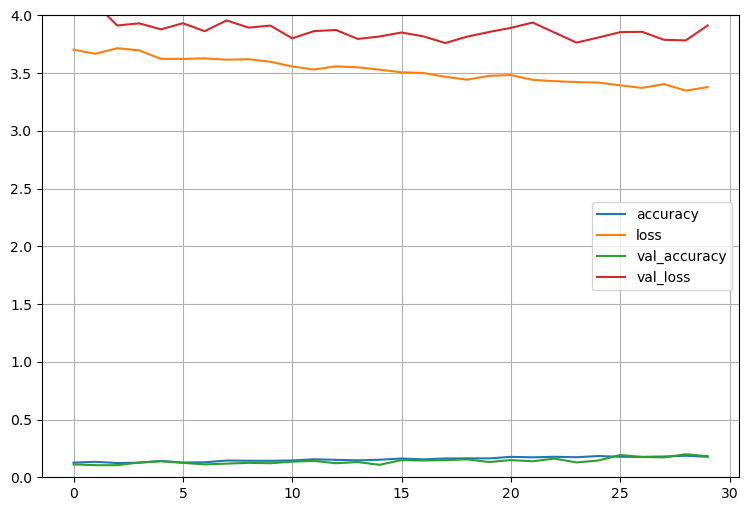

In [24]:
# Loading saved model weights and setting them to the model arch

model = create_model_wlasl100(frames, width, height, channels, output)
model.summary()
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights('./Training_Results/saved_models/model_weights.weights.h5')

path = './Training_Results/saved_models/'
checkpoint_cb = ModelCheckpoint(path + 'best_model_100.keras', save_best_only=True)

history = model.fit(
                train_generator,  
                validation_data=val_generator, 
                epochs=150,  
                initial_epoch=120,  
                callbacks=[checkpoint_cb]  
            )

model.save_weights('./Training_Results/saved_models/model_weights_150_v1.weights.h5')

# save learning curves
if not os.path.isdir('./Training_Results/plots150/'):
    os.mkdir('./Training_Results/plots150/')

print('\nSaving learning curves graph . . .')
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.savefig('./Training_Results/plots150/learning_curves.png')

In [ ]:
model = create_model_wlasl100(frames, width, height, channels, output)
model.summary()
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights('./Training_Results/saved_models/model_weights_150_v1.weights.h5')

path = './Training_Results/saved_models/'
checkpoint_cb = ModelCheckpoint(path + 'best_model_100.keras', save_best_only=True)

history = model.fit(
                train_generator,  
                validation_data=val_generator, 
                epochs=300,  
                initial_epoch=150,  
                callbacks=[checkpoint_cb]  
            )

model.save_weights('./Training_Results/saved_models/model_weights_300_v1.weights.h5')

# save learning curves
if not os.path.isdir('./Training_Results/plots300/'):
    os.mkdir('./Training_Results/plots300/')

print('\nSaving learning curves graph . . .')
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.savefig('./Training_Results/plots300/learning_curves.png')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_8              │ (None, 10, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 10, 256)        │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        15,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,931,594 (15.00 MB)

 Trainable params: 3,896,970 (14.87 MB)

 Non-trainable params: 34,624 (135.25 KB)

Epoch 151/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.1855 - loss: 3.3244 - val_accuracy: 0.1892 - val_loss: 3.8550
Epoch 152/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.2152 - loss: 3.2842 - val_accuracy: 0.1655 - val_loss: 3.9740
Epoch 153/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.2028 - loss: 3.2998 - val_accuracy: 0.1858 - val_loss: 3.6845
Epoch 154/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.1969 - loss: 3.2585 - val_accuracy: 0.1689 - val_loss: 3.9774
Epoch 155/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1938 - loss: 3.3611 - val_accuracy: 0.1689 - val_loss: 3.8590
Epoch 156/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.1817 - loss: 3.3190 - val_accuracy: 0.1791 - val_loss: 3.7903
Epoch 157/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.2159 - loss: 3.2999 - val_accuracy: 0.1655 - val_loss: 4.0638
Epoch 158/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1971 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



157/157 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4561 - loss: 2.1795 - val_accuracy: 0.3108 - val_loss: 4.1236
Epoch 291/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4254 - loss: 2.3304 - val_accuracy: 0.3176 - val_loss: 3.7301
Epoch 292/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4632 - loss: 2.1140 - val_accuracy: 0.3176 - val_loss: 3.8743
Epoch 293/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4193 - loss: 2.2284 - val_accuracy: 0.3277 - val_loss: 3.7352
Epoch 294/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4410 - loss: 2.2019 - val_accuracy: 0.3041 - val_loss: 4.1129
Epoch 295/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4295 - loss: 2.2485 - val_accuracy: 0.3209 - val_loss: 4.0110
Epoch 296/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.4272 - loss: 2.2373 - val_accuracy: 0.2939 - val_loss: 3.7554
Epoch 297/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4299 - loss: 2.2198 

In [ ]:
# Scratch model building
print('\nModel building and compiling . . .')
model = create_model_wlasl100(frames, width, height, channels, output)
model.summary()
# model compiling
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

if not os.path.isdir('./Training_Results/'):
    os.mkdir('./Training_Results/')

# callbacks creation
if not os.path.isdir('./Training_Results/saved_models/'):
    os.mkdir('./Training_Results/saved_models/')

# save the best model each time
path = './Training_Results/saved_models/'
checkpoint_cb = ModelCheckpoint(path + 'best_model_100.keras', save_best_only=True)

# start training
print('\nStart training . . .')
learn_epochs = 100
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=learn_epochs,
                    callbacks=[checkpoint_cb])

# save learning curves
if not os.path.isdir('./Training_Results/plots100/'):
    os.mkdir('./Training_Results/plots100/')

print('\nSaving learning curves graph . . .')
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.savefig('./Training_Results/plots/learning_curves.png')

In [11]:
model = create_model_wlasl100(frames, width, height, channels, output)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights('./Training_Results/saved_models/model_weights_300_v1.weights.h5')

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'Adam', because it has 2 variables whereas the saved optimizer has 342 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
# instantiation of test generator
TEST_PATH = '../video_data/WLASL_100/test/'
# transform labels from string to number
labels = labels_to_number(TEST_PATH)
# load dataset as dict
y_test_dict = videos_to_dict(TEST_PATH, labels)
# get video paths (without labels)
X_test = list(y_test_dict.keys())

print('\nTest generator')
test_generator = VideoFrameGenerator(
    list_IDs=X_test,
    labels=y_test_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=channels,
    n_sequence=frames,
    shuffle=False,
    type_gen='test'
)


['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue', 'book', 'bowling', 'brown', 'but', 'can', 'candy', 'chair', 'change', 'cheat', 'city', 'clothes', 'color', 'computer', 'cook', 'cool', 'corn', 'cousin', 'cow', 'dance', 'dark', 'deaf', 'decide', 'doctor', 'dog', 'drink', 'eat', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'hearing', 'help', 'hot', 'how', 'jacket', 'kiss', 'language', 'last', 'later', 'letter', 'like', 'man', 'many', 'medicine', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'right', 'same', 'school', 'secretary', 'shirt', 'short', 'son', 'study', 'table', 'tall', 'tell', 'thanksgiving', 'thin', 'thursday', 'time', 'walk', 'want', 'what', 'white', 'who', 'woman', 'work', 'wrong', 'year', 'yes']

Test generator
Videos: 235, batches per epoch: 29


In [14]:
# evaluate the best model on test set
print('\nEvaluating the best model on test set . . .')
eval_loss, eval_acc = model.evaluate(test_generator)

['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue', 'book', 'bowling', 'brown', 'but', 'can', 'candy', 'chair', 'change', 'cheat', 'city', 'clothes', 'color', 'computer', 'cook', 'cool', 'corn', 'cousin', 'cow', 'dance', 'dark', 'deaf', 'decide', 'doctor', 'dog', 'drink', 'eat', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'hearing', 'help', 'hot', 'how', 'jacket', 'kiss', 'language', 'last', 'later', 'letter', 'like', 'man', 'many', 'medicine', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'right', 'same', 'school', 'secretary', 'shirt', 'short', 'son', 'study', 'table', 'tall', 'tell', 'thanksgiving', 'thin', 'thursday', 'time', 'walk', 'want', 'what', 'white', 'who', 'woman', 'work', 'wrong', 'year', 'yes']

Test generator
Videos: 235, batches per epoch: 29

Evaluating the best model on test set . . .
29/29 ━━━━━━━━

In [114]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.metrics import top_k_accuracy_score
import numpy as np

def evaluate_generator(model, generator):
    """
    Evaluate the model on a VideoFrameGenerator and return true labels and predictions.

    Args:
        model: Trained Keras model.
        generator: VideoFrameGenerator for evaluation.

    Returns:
        Tuple of (true_labels, predicted_labels).
    """
    true_labels = []
    predicted_labels = []
    pred_probs = []
    # Loop through all batches in the generator
    for batch_x, batch_y in generator:
        # Predict probabilities for the batch
        preds = model.predict(batch_x)
        # Store true labels and predicted labels
        true_labels.extend(batch_y)  # Ground truth labels
        predicted_labels.extend(np.argmax(preds, axis=-1))  # Predicted class indices
        pred_probs.extend(preds)
        # Stop iteration if the generator is exhausted
        if len(true_labels) >= len(generator.list_IDs):
            break

    return np.array(true_labels), np.array(pred_probs), np.array(predicted_labels)

def calculate_top_k_accuracy(model, generator, k_values=[1, 5, 10]):
    """
    Calculate top-k accuracy for a given generator and model.
    :param generator: The data generator (train, validation, or test).
    :param model: The trained model.
    :param k_values: List of top-k values to calculate accuracy for (default: [1, 5, 10]).
    :return: Dictionary of top-k accuracy values.
    """
    # Initialize lists to hold true labels and predicted probabilities
    y_true = []
    y_pred_probs = []

    # Iterate through the generator
    for X_batch, y_batch in generator:
        
        # Get model predictions (probabilities)
        y_pred_batch = model.predict(X_batch, batch_size=generator.batch_size)
        
        # Append true labels and predicted probabilities
        y_true.append(y_batch)
        y_pred_probs.append(y_pred_batch)

    # Convert to numpy arrays for sklearn metrics calculation
    y_true = np.concatenate(y_true, axis=0)
    y_pred_probs = np.concatenate(y_pred_probs, axis=0)

    # Initialize a dictionary to store top-k accuracy results
    top_k_accuracy = {}

    # Calculate top-k accuracy for each k in k_values
    for k in k_values:
        top_k_accuracy[k] = top_k_accuracy_score(y_true, y_pred_probs, k=k)

    return top_k_accuracy

def plot_top_k_accuracy_histogram(train_accuracies, val_accuracies, test_accuracies):
    """
    Plots a histogram for top-k accuracy values for train, validation, and test datasets.

    :param train_accuracies: Dictionary containing top-k accuracies for the train set.
    :param val_accuracies: Dictionary containing top-k accuracies for the validation set.
    :param test_accuracies: Dictionary containing top-k accuracies for the test set.
    :param k_values: List of top-k values to plot (default: [1, 5, 10]).
    """
    # Positions for each top-k accuracy
    index = np.arange(len(k_values))

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plotting the bars for train, validation, and test accuracies
    ax.plot(index, [train_accuracies[k] for k in range(3)], linewidth=3, marker='o', label='Train', color='orchid')
    ax.plot(index, [val_accuracies[k] for k in range(3)], linewidth=3, marker='o', label='Validation', color='deeppink')
    ax.plot(index, [test_accuracies[k] for k in range(3)], linewidth=3, marker='o', label='Test', color='darkmagenta')

    # Labeling the graph
    ax.set_xlabel('Top-k Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_title('Top-k Accuracy for Train, Validation, and Test Sets')
    ax.set_xticks(index)
    ax.set_xticklabels([f'Top-{k}' for k in k_values])
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
##### Evaluate on train generator
print("\nEvaluating on train set...")
y_train_true, y_train_pred_probs, y_train_pred = evaluate_generator(model, train_generator)

# Classification report
print("\Train Set Classification Report:")
print(classification_report(y_train_true, y_train_pred, zero_division=0))

# Compute F1 Score and Recall, handling undefined cases
train_f1 = f1_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=0)


print(f"Train Set F1 Score: {train_f1:.4f}")
print(f"Train Set Precision: {train_precision:.4f}")
print(f"Train Set Recall: {train_recall:.4f}")

In [45]:
# Evaluate on validation generator
print("\nEvaluating on validation set...")
y_val_true, y_val_pred_probs, y_val_pred = evaluate_generator(model, val_generator)

# Classification report
print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, zero_division=0))

# Compute F1 Score and Recall, handling undefined cases
val_f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
val_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)


print(f"Validation Set F1 Score: {val_f1:.4f}")
print(f"Validation Set Precision: {val_precision:.4f}")
print(f"Validation Set Recall: {val_recall:.4f}")



Evaluating on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━

In [46]:
# Evaluate on test generator
print("\nEvaluating on test set...")
y_test_true, y_test_pred_probs, y_test_pred = evaluate_generator(model, test_generator)
print(y_test_true.shape)
print(y_test_pred_probs.shape)

# Classification report
print("\Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred, zero_division=0))

# Compute F1 Score and Recall, handling undefined cases
test_f1 = f1_score(y_test_true, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true, y_test_pred, average='weighted', zero_division=0)
test_precision = precision_score(y_test_true, y_test_pred, average='weighted', zero_division=0)


print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")



Evaluating on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [18]:
# Optionally, for test accuracy, you can calculate it manually after training:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.5589 - loss: 1.8771
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 914ms/step - accuracy: 0.3294 - loss: 3.8934
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.2221 - loss: 4.2347


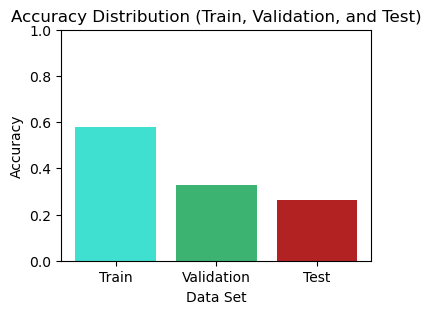

In [19]:
accuracies = [train_acc, val_acc, test_acc]
labels = ['Train', 'Validation', 'Test']

# Plotting histogram
plt.figure(figsize=(4, 3))
plt.bar(labels, accuracies, color=['turquoise', 'mediumseagreen', 'firebrick'])

plt.title('Accuracy Distribution (Train, Validation, and Test)')
plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(True, axis='y', linestyle='--', alpha=0)
plt.show()

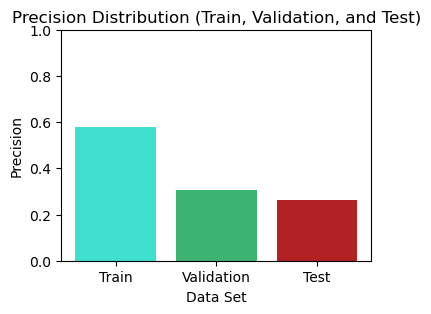

In [20]:
precision = [train_precision, val_precision, test_precision]
labels = ['Train', 'Validation', 'Test']

# Plotting histogram
plt.figure(figsize=(4, 3))
plt.bar(labels, precision, color=['turquoise', 'mediumseagreen', 'firebrick'])

plt.title('Precision Distribution (Train, Validation, and Test)')
plt.xlabel('Data Set')
plt.ylabel('Precision')
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(True, axis='y', linestyle='--', alpha=0)
plt.show()

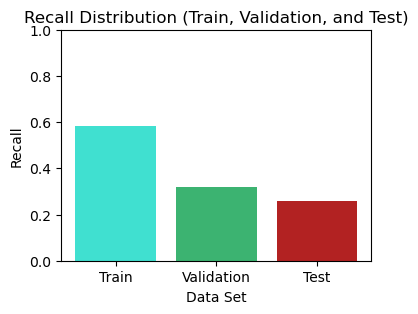

In [21]:
recall = [train_recall, val_recall, test_recall]
labels = ['Train', 'Validation', 'Test']

# Plotting histogram
plt.figure(figsize=(4, 3))
plt.bar(labels, recall_, color=['turquoise', 'mediumseagreen', 'firebrick'])

plt.title('Recall Distribution (Train, Validation, and Test)')
plt.xlabel('Data Set')
plt.ylabel('Recall')
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(True, axis='y', linestyle='--', alpha=0)
plt.show()

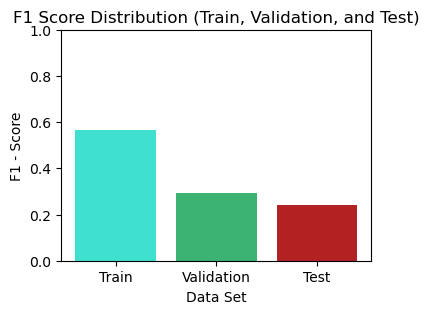

In [92]:
f1 = [train_f1, val_f1, test_f1]
labels = ['Train', 'Validation', 'Test']

# Plotting histogram
plt.figure(figsize=(4, 3))
plt.bar(labels, f1, color=['turquoise', 'mediumseagreen', 'firebrick'])

plt.title('F1 Score Distribution (Train, Validation, and Test)')
plt.xlabel('Data Set')
plt.ylabel('F1 - Score')
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(True, axis='y', linestyle='--', alpha=0)
plt.show()

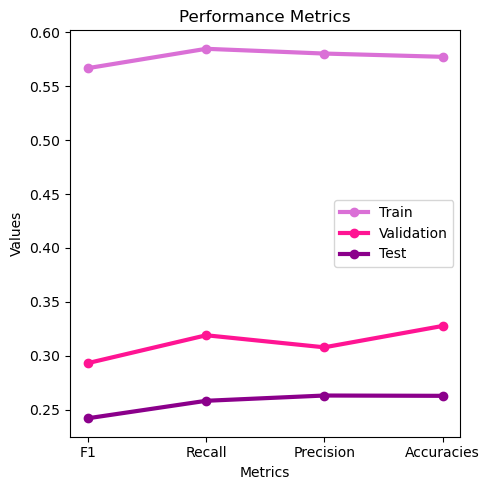

In [116]:
# Positions for each top-k accuracy
index = [1,2,3,4]
train_metrics = [f1[0], recall[0], precision[0], accuracies[0]]
val_metrics = [f1[1], recall[1], precision[1], accuracies[1]]
test_metrics = [f1[2], recall[2], precision[2], accuracies[2]]
labels = ['Train', 'Validation', 'Test']

# Create the figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plotting the bars for train, validation, and test accuracies
ax.plot(index, [train_metrics[k] for k in range(4)], linewidth=3, marker='o', label='Train', color='orchid')
ax.plot(index, [val_metrics[k] for k in range(4)], linewidth=3, marker='o', label='Validation', color='deeppink')
ax.plot(index, [test_metrics[k] for k in range(4)], linewidth=3, marker='o', label='Test', color='darkmagenta')

# Labeling the graph
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Metrics')
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['F1', 'Recall', 'Precision', 'Accuracies'])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [51]:
# Calculate top-1, top-5, and top-10 accuracy for train, validation, and test generators
k_values = [1, 5, 10]
top_k_train = {}
# Calculate top-k accuracy for each k in k_values
for k in k_values:
    top_k_train[k] = top_k_accuracy_score(y_train_true, y_train_pred_probs, k=k)

top_k_val = {}
# Calculate top-k accuracy for each k in k_values
for k in k_values:
    top_k_val[k] = top_k_accuracy_score(y_val_true, y_val_pred_probs, k=k)

top_k_test = {}
# Calculate top-k accuracy for each k in k_values
for k in k_values:
    top_k_test[k] = top_k_accuracy_score(y_test_true, y_test_pred_probs, k=k)

# print(top_k_test)

# top_k_train = calculate_top_k_accuracy(model, train_generator, k_values=[1, 5, 10])
# top_k_val = calculate_top_k_accuracy(model, val_generator, k_values=[1, 5, 10])
# top_k_test = calculate_top_k_accuracy(model, test_generator, k_values=[1, 5, 10])

# Print top-k accuracies for train, validation, and test sets
print(f"Top-1 Accuracy (Train): {top_k_train[1]:.4f}")
print(f"Top-5 Accuracy (Train): {top_k_train[5]:.4f}")
print(f"Top-10 Accuracy (Train): {top_k_train[10]:.4f}")

print(f"Top-1 Accuracy (Validation): {top_k_val[1]:.4f}")
print(f"Top-5 Accuracy (Validation): {top_k_val[5]:.4f}")
print(f"Top-10 Accuracy (Validation): {top_k_val[10]:.4f}")

print(f"Top-1 Accuracy (Test): {top_k_test[1]:.4f}")
print(f"Top-5 Accuracy (Test): {top_k_test[5]:.4f}")
print(f"Top-10 Accuracy (Test): {top_k_test[10]:.4f}")

Top-1 Accuracy (Train): 0.5815
Top-5 Accuracy (Train): 0.6820
Top-10 Accuracy (Train): 0.7294
Top-1 Accuracy (Validation): 0.3191
Top-5 Accuracy (Validation): 0.5000
Top-10 Accuracy (Validation): 0.5789
Top-1 Accuracy (Test): 0.2583
Top-5 Accuracy (Test): 0.4625
Top-10 Accuracy (Test): 0.5708


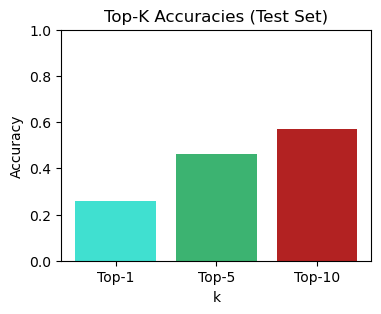

In [52]:
top_k = [top_k_test[1], top_k_test[5], top_k_test[10]]
labels = ['Top-1', 'Top-5', 'Top-10']

# Plotting histogram
plt.figure(figsize=(4, 3))
plt.bar(labels, top_k, color=['turquoise', 'mediumseagreen', 'firebrick'])

plt.title('Top-K Accuracies (Test Set)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(True, axis='y', linestyle='--', alpha=0)
plt.show()

[0.5814873417721519, 0.6819620253164557, 0.7294303797468354]


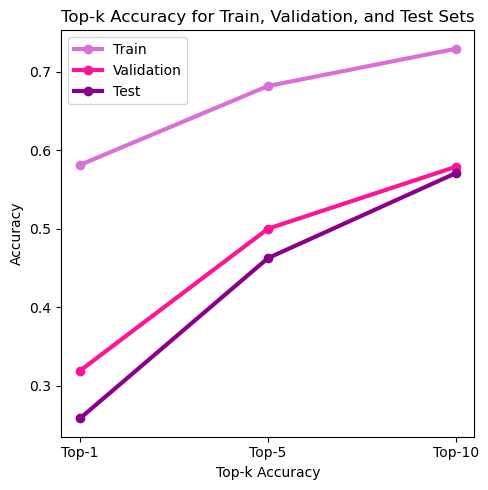

In [115]:
# Example usage:
# Assuming you have calculated these values from the `calculate_top_k_accuracy` function
train_accuracies = [top_k_train[1], top_k_train[5], top_k_train[10]]
print(train_accuracies)
val_accuracies = [top_k_val[1], top_k_val[5], top_k_val[10]]
test_accuracies = [top_k_test[1], top_k_test[5], top_k_test[10]]

# Plot the histogram
plot_top_k_accuracy_histogram(train_accuracies, val_accuracies, test_accuracies)



['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue', 'book', 'bowling', 'brown', 'but', 'can', 'candy', 'chair', 'change', 'cheat', 'city', 'clothes', 'color', 'computer', 'cook', 'cool', 'corn', 'cousin', 'cow', 'dance', 'dark', 'deaf', 'decide', 'doctor', 'dog', 'drink', 'eat', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'hearing', 'help', 'hot', 'how', 'jacket', 'kiss', 'language', 'last', 'later', 'letter', 'like', 'man', 'many', 'medicine', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'right', 'same', 'school', 'secretary', 'shirt', 'short', 'son', 'study', 'table', 'tall', 'tell', 'thanksgiving', 'thin', 'thursday', 'time', 'walk', 'want', 'what', 'white', 'who', 'woman', 'work', 'wrong', 'year', 'yes']


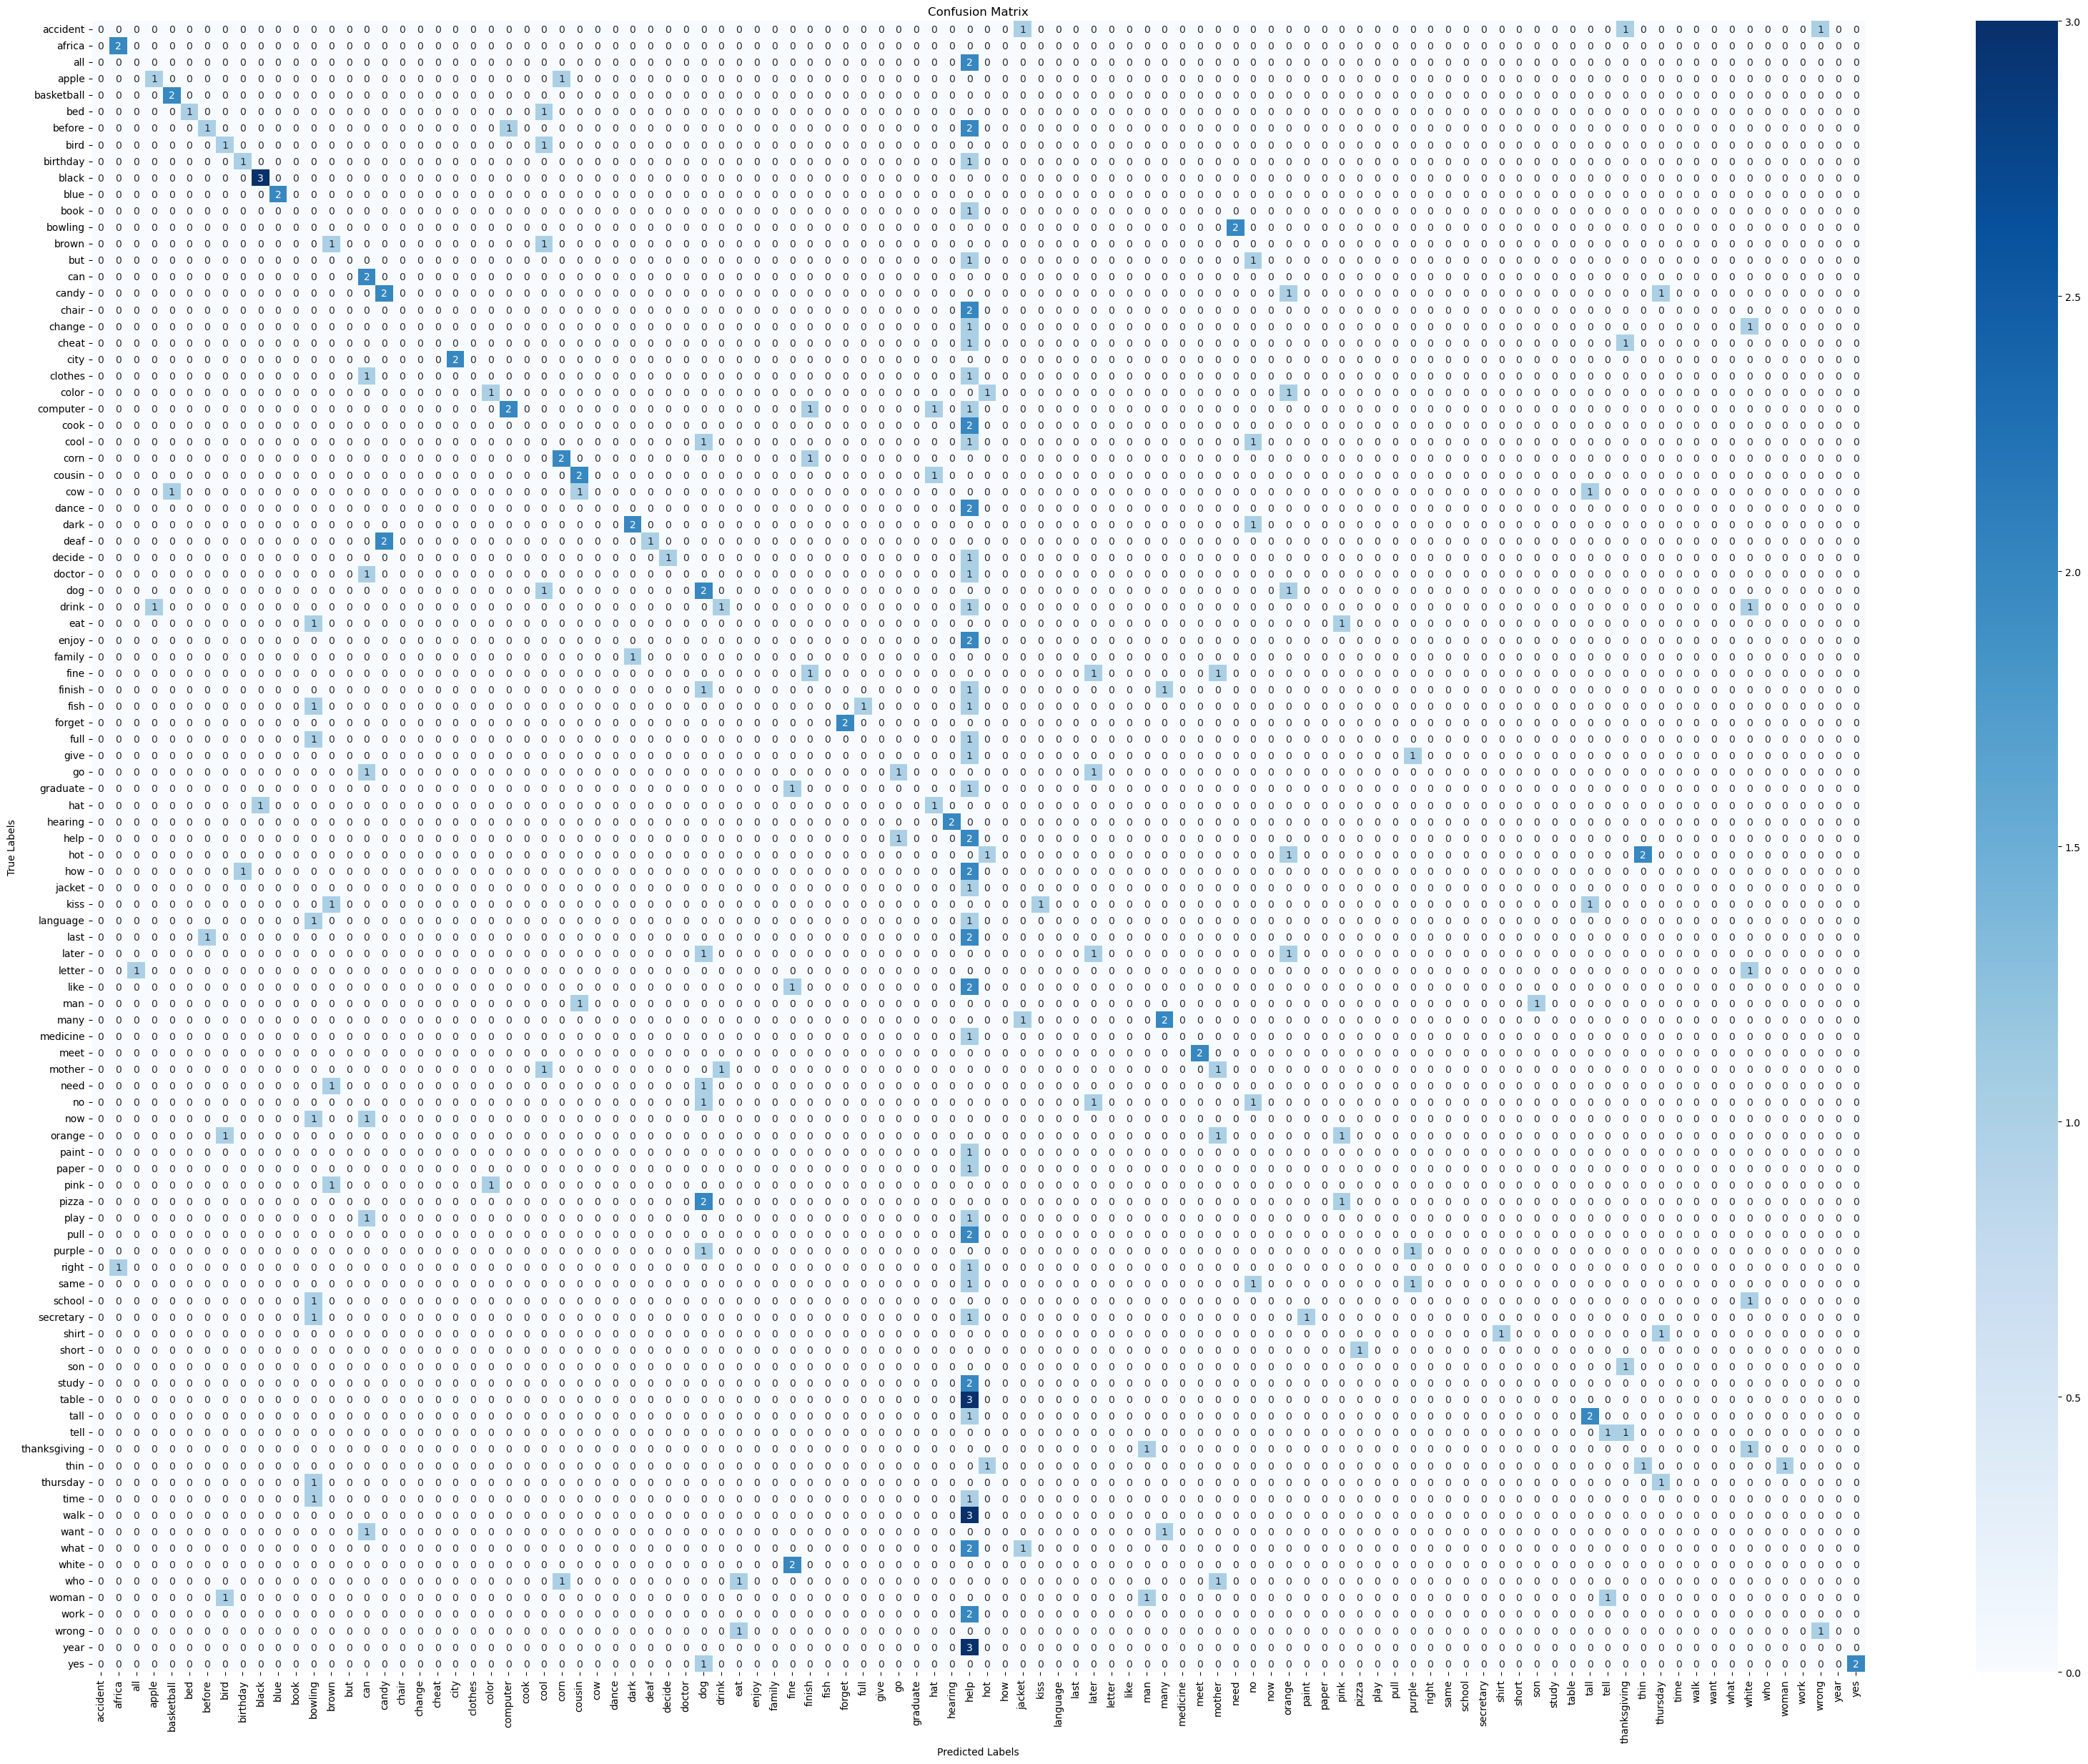

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_true are the true labels and X_test is the test data

labels = labels_to_number(TEST_PATH)
# Generate the confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(40, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()